# IMPORTS & CONFIGS 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import os
import glob
from scipy import signal
from scipy.stats import norm
from scipy.optimize import curve_fit

# INITIAL DATA PROCESSING

In [2]:
def data_start(dir: str) -> object:
    main_df = pd.DataFrame()
    
    filepaths = glob.glob(os.path.join(dir, "*.csv"))
    
    for files in filepaths:
        df = pd.read_csv(files, sep=';',decimal=',', index_col=False, skiprows=8, usecols=range(18), encoding='iso-8859-1')
        df['datetime'] = pd.to_datetime(df.iloc[:, 0] + ' ' + df.iloc[:, 1])
        # Drop the original date and time columns by index
        df.drop(df.columns[[0, 1]], axis=1, inplace=True)
        df.replace(-9999, np.nan, inplace=True)
        df = df.dropna()
        
        
        df['year_month'] = df['datetime'].dt.to_period('M')
        df.drop(df.columns[[-2]], axis=1, inplace=True)
        
        # Group by year and month and calculate the average of 'x' and 'y'

        monthly_avg = df.groupby('year_month').mean()
        monthly_avg.reset_index(inplace=True)
        monthly_avg['year_month'] = monthly_avg['year_month'].astype(str)
        if len(main_df) == 0:
            main_df = monthly_avg
        else:
            main_df = pd.concat([main_df, monthly_avg])

    
    del df
    del monthly_avg
    main_df = main_df.sort_values("year_month").reset_index()
    
    return main_df

In [3]:
def plot(df: object) -> None:
    plt.figure(figsize=(10, 5))

    # Plot the 'x' column
    for i in df.columns:
        if i != 'year_month':
            plt.plot(df.index, df[i], linestyle='-', label=i)  

    # Adding titles and labels
    plt.title('Data x Months')
    plt.xlabel('DATA')
    plt.ylabel('YEAR_MOUNTH')

    # Adding a legend
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()

# MAIN

C:\Users\Lucas\AppData\Local\Temp\ipykernel_19228\3581725063.py:15: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['datetime'].dt.to_period('M')
C:\Users\Lucas\AppData\Local\Temp\ipykernel_19228\3581725063.py:15: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['datetime'].dt.to_period('M')
C:\Users\Lucas\AppData\Local\Temp\ipykernel_19228\3581725063.py:15: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['datetime'].dt.to_period('M')
C:\Users\Lucas\AppData\Local\Temp\ipykernel_19228\3581725063.py:15: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['datetime'].dt.to_period('M')
C:\Users\Lucas\AppData\Local\Temp\ipykernel_19228\3581725063.py:15: UserWarning: Converting to PeriodArray/Index representation will drop timezo

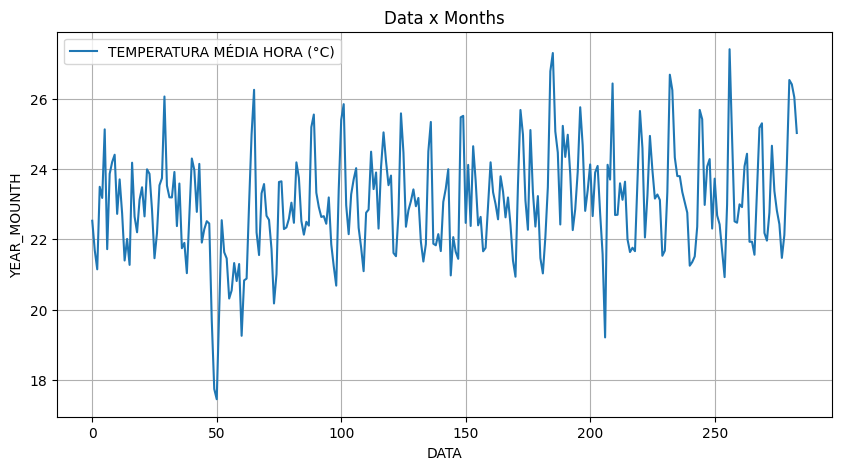

In [9]:
data_dir = "../Data"
df_main = data_start(data_dir)
df_main['TEMPERATURA MÉDIA HORA (°C)'] = df_main[['TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)', 'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)']].mean(axis=1)
df_main['UMIDADE REL. MÉDIA HORA (%)'] = df_main[['UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)']].mean(axis=1)
# df_treated = df_main[['TEMPERATURA MÉDIA HORA (°C)', 'UMIDADE REL. MÉDIA HORA (%)', 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)', 'year_month']]
df_treated = df_main[['TEMPERATURA MÉDIA HORA (°C)', 'year_month']]
plot(df_treated)

C:\Users\Lucas\AppData\Local\Temp\ipykernel_19228\1333587281.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_treated['denoise_temp'] = apply_convolution(df_treated['TEMPERATURA MÉDIA HORA (°C)'], 10)
C:\Users\Lucas\AppData\Local\Temp\ipykernel_19228\1333587281.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_treated['MA'] = df_treated['TEMPERATURA MÉDIA HORA (°C)'].rolling(window = 10).mean()


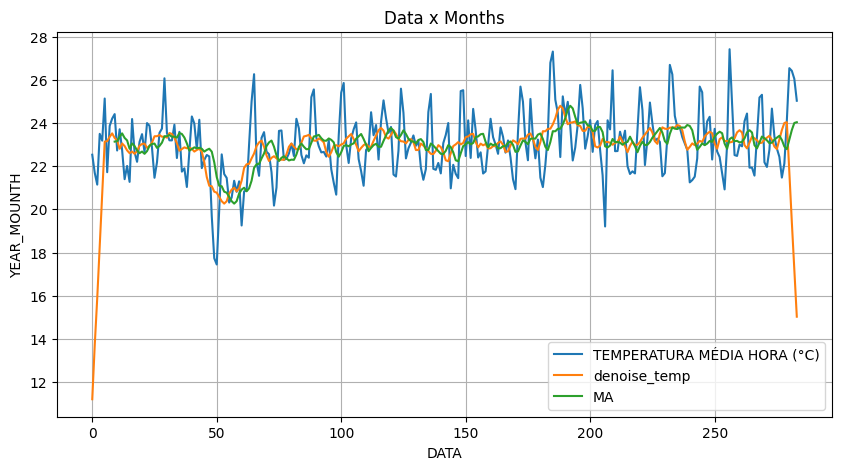

C:\Users\Lucas\AppData\Local\Temp\ipykernel_19228\1333587281.py:15: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_treatedm['s'][df_treatedm['s'].tail(n=1).index] = 0


<Axes: >

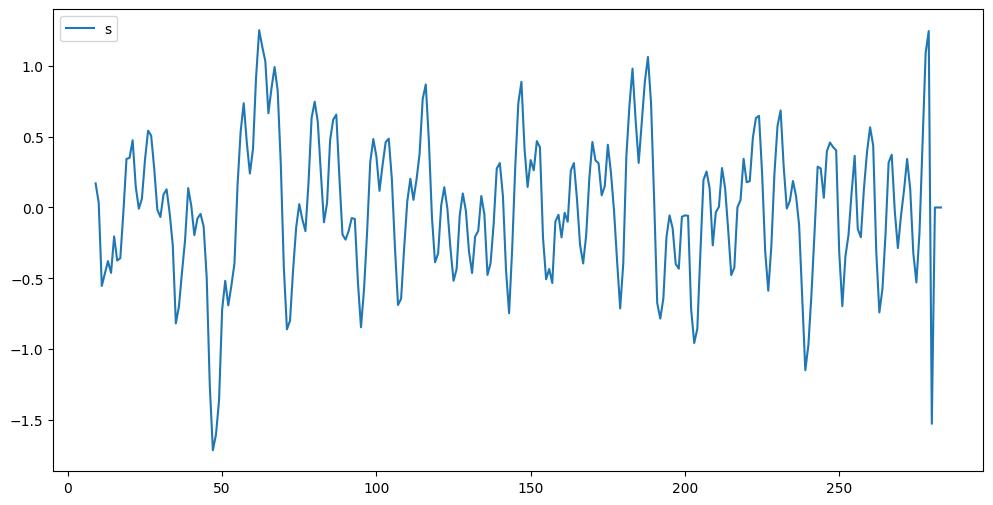

In [17]:
def apply_convolution(x, window):
    conv = np.repeat([0., 1., 0.], window)
    filtered = signal.convolve(x, conv, mode='same') / window
    return filtered
lookback = 12*23
df_treated['denoise_temp'] = apply_convolution(df_treated['TEMPERATURA MÉDIA HORA (°C)'], 10)
# plot(df_treated[['TEMPERATURA MÉDIA HORA (°C)', 'year_month']])
df_treated['MA'] = df_treated['TEMPERATURA MÉDIA HORA (°C)'].rolling(window = 10).mean()
plot(df_treated)
# plt.ylabel('Temperature (deg C)')
# df_treated['MA'].plot(figsize=(8,4), color="tab:red", title="Rolling mean over annual periods")
df_treatedm = pd.DataFrame()
df_treatedm['s'] = df_treated['denoise_temp'] - df_treated['MA']
df_treatedm['s'] = df_treatedm['s'].dropna()
df_treatedm['s'][df_treatedm['s'].tail(n=1).index] = 0
df_treatedm['s'][df_treatedm['s'].tail(n=1).index-1] = 0
df_treatedm['s'][df_treatedm['s'].tail(n=1).index-2] = 0
df_treatedm.plot(figsize=(12,6))

C:\Users\Lucas\AppData\Roaming\Python\Python312\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)


ValueError: x and y must have same first dimension, but have shapes (1,) and (284,)

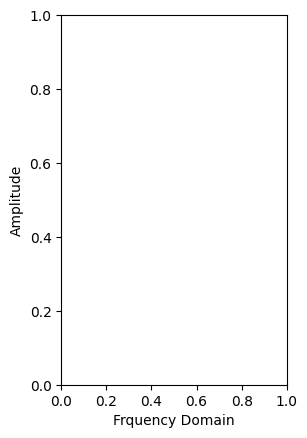

In [15]:
fft_ = np.fft.fft(df_treated['TEMPERATURA MÉDIA HORA (°C)'])
fft_freq = fftfreq = np.fft.fftfreq(len(df_treated['TEMPERATURA MÉDIA HORA (°C)']))*len(df_treated['TEMPERATURA MÉDIA HORA (°C)'])/(df_treated.index.max()-df_treated.index.min())
plt.subplot(1, 2, 1)
plt.xlabel("Frquency Domain")
plt.ylabel("Amplitude")
plt.plot(len(fft_), fft_)
plt.subplot(1, 2, 2)
plt.show()